# Importing libraries and configuring the environment

# Importing libraries, dataset and configuring the environment

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import networkx as nx
import seaborn as sns
from scipy import integrate, optimize
from community import community_louvain
from warnings import filterwarnings


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
filterwarnings('ignore')

plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})

a = pd.read_csv('dfsend.csv')[['sender','recipient1','date']]


# Network preprocessing

Upon importing the dataset, all emails exchanged with accounts external to the company were filtered out. Subsequently, emails sent by any account to itself were also excluded, as they did not fall within the scope of the research. A new dataframe was then generated, comprising only the sender, receiver, email date, and the count of emails exchanged between the respective accounts.

In [2]:
pattern = r'^\w+\.\w+@enron\.com$'
filtered_emails = [email for email in a.sender if re.match(pattern, email)]
a=a[a['sender'].isin(filtered_emails) & a['recipient1'].isin(filtered_emails)]
a=a[a.sender != a.recipient1]

a['date'] = a['date'].str.split().str[0]
a['date']=pd.to_datetime(a['date'])
a['date']=a['date'].dt.strftime('%Y-%m')
a=a.groupby(['sender','recipient1','date']).size().reset_index(name='counts')
a=a.sort_values(by=['date']).reset_index(drop=True)

a.head()


,sender,recipient1,date,counts
0,sara.shackleton@enron.com,sheila.glover@enron.com,1979-12,1
1,kay.mann@enron.com,brian.barto@enron.com,1979-12,1
2,kay.mann@enron.com,ben.jacoby@enron.com,1979-12,2
3,susan.scott@enron.com,jeffery.fawcett@enron.com,1979-12,2
4,richard.sanders@enron.com,matthias.lee@enron.com,1979-12,1


The dataset was divided into four distinct datasets, with each one corresponding to a specific year. This division was undertaken to facilitate the examination of the network's evolution over time. The analysis primarily concentrated on the period from 1999 to 2002, as the volume of emails exchanged in preceding years was deemed insufficient to be considered statistically significant.

In [3]:
df_1999=a[(a['date']>='1999-01') & (a['date']<='1999-12')]
df_2000=a[(a['date']>='2000-01') & (a['date']<='2000-12')]
df_2001=a[(a['date']>='2001-01') & (a['date']<='2001-12')]
df_2002=a[(a['date']>='2002-01') & (a['date']<='2002-12')]

# Disparity filter for edge weights' significance score computing 

Given the network's high density and complexity, an additional preprocessing step under consideration is Disparity Filtering. This process will be executed on a yearly basis in the subsequent sections.

The provided function calculates significance scores (alpha) for weighted edges within a graph G, following the definition in Serrano et al. 2009. Starting from a given G, which is a weighted NetworkX graph, the function produces a weighted graph where each edge is assigned a significance score (alpha). This score is determined as the ratio between the edge's weight and the average weight of the edges incident to its endpoints, serving as a measure of the edge's importance in the network.

References: M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.

In [4]:
def disparity_filter(G, weight='weight'):
    
    B = nx.Graph()
    for u in G:

        k = len(G[u])

        if k > 1:
            sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
            
            for v in G[u]:
                w = G[u][v][weight]
                p_ij = float(np.absolute(w))/sum_w
                alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                B.add_edge(u, v, weight=w, alpha=float('%.4f' % alpha_ij))
    return B

# Alpha cut for disparity filter

The function below takes as input a graph G and a significance score alpha and returns a graph with only the edges with a significance score lower than alpha. It is used to filter out the edges with a low significance score, i.e. the edges that are not important for the network structure.

In [5]:
def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or'):
    
    B = nx.Graph() 
    for u, v, w in G.edges(data=True):
        
        try:
            alpha = w['alpha']

        except KeyError:
            alpha = 1
            
        if alpha<alpha_t:

            B.add_edge(u,v, weight=w[weight])

    return B                


# 1999

The initial year under scrutiny is 1999. The analysis commences with the establishment of a new graph, wherein edges are added between the sender and receiver of each email, incorporating the quantity of emails exchanged as the weight. Subsequently, the disparity filter is employed to eliminate edges with low significance scores. To conclude this step, the computation of the four major centrality measures for each node takes place, a crucial aspect in our analysis. Subsequently, a dataframe is constructed, housing the four centrality measures for each node.

In [6]:
G1999 = nx.Graph()

l=[]
for i,j,k in zip(df_1999['sender'], df_1999['recipient1'], df_1999['counts']):
    l.append((i,j,k))
G1999.add_weighted_edges_from(l)

G1999 = disparity_filter(G1999)
G1999 = disparity_filter_alpha_cut(G1999)

degree_centrality = nx.degree_centrality(G1999)
btw_centrality = nx.betweenness_centrality(G1999, weight='weights')
closeness_centrality = nx.closeness_centrality(G1999)
eig_betw = nx.eigenvector_centrality(G1999, weight='weights')

df_nodes = pd.DataFrame()
df_nodes['nodes'] = [i for i in G1999]
df_nodes['degree_cent']  = dict(degree_centrality).values()
df_nodes['btw_cent']  = dict(btw_centrality).values()    
df_nodes['closeness_cent']  = dict(closeness_centrality).values()   
df_nodes['eigenvector_cent']  = dict(eig_betw).values()

df_nodes.head()


,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent
0,mark.taylor@enron.com,0.125926,0.130920,0.273344,0.431660
1,carol.clair@enron.com,0.011111,0.001184,0.217227,0.112600
2,christian.yoder@enron.com,0.011111,0.009108,0.215325,0.068832
3,martin.rosell@enron.com,0.003704,0.000000,0.188513,0.054310
4,tana.jones@enron.com,0.140741,0.114506,0.248494,0.426666


To facilitate comparison, the centrality measures, which exhibit distinct distributions, have been normalized. This involved a straightforward approach where each value was divided by the sum of all values. Consequently, the maximum value in each distribution equates to 1.

To determine the final score of each node, weights were assigned to each metric. Given the dense and intricate nature of the network, it was deemed essential to attribute varying degrees of importance to each metric. The weights were distributed as follows:

- Degree centrality: 0.1
- Betweenness centrality: 0.2
- Closeness centrality: 0.3
- Eigenvector centrality: 0.4

The final score of each node was computed by summing the weighted centrality measures. A new column in the dataframe was then created to accommodate these final scores, and the dataframe was subsequently sorted in descending order. This arrangement ensures that the most significant nodes occupy the top positions in the dataframe.

In [7]:
df_nodes['degree_cent'] = df_nodes['degree_cent']/df_nodes['degree_cent'].sum()
df_nodes['btw_cent'] = df_nodes['btw_cent']/df_nodes['btw_cent'].sum()
df_nodes['closeness_cent'] = df_nodes['closeness_cent']/df_nodes['closeness_cent'].sum()
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']/df_nodes['eigenvector_cent'].sum()

df_nodes['degree_cent'] = df_nodes['degree_cent']*10
df_nodes['btw_cent'] = df_nodes['btw_cent']*20
df_nodes['closeness_cent'] = df_nodes['closeness_cent']*30
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']*40

df_nodes['total'] = df_nodes['degree_cent']+df_nodes['btw_cent']+df_nodes['closeness_cent']+df_nodes['eigenvector_cent']

df_nodes=df_nodes.sort_values(by=['total'], ascending=False).reset_index(drop=True)

df_nodes.head()

,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent,total
0,sara.shackleton@enron.com,0.704698,3.167702,0.241590,1.943056,6.057046
1,mark.taylor@enron.com,0.570470,2.627074,0.265078,2.171014,5.633636
2,tana.jones@enron.com,0.637584,2.297709,0.240980,2.145897,5.322170
3,jeffrey.hodge@enron.com,0.134228,1.596081,0.242203,0.842914,2.815427
4,richard.sanders@enron.com,0.369128,1.625129,0.211592,0.290213,2.496061


Finally, a list encompassing the top 75 nodes of the network was generated, serving as the foundation for a new dataframe. This new dataframe exclusively features the most pivotal nodes within the network. The purpose of this dataframe is to facilitate the creation of subgraphs corresponding to each year in the analysis. These subgraphs will specifically pertain to the most significant nodes, streamlining the focus of the investigation on the network's key elements for each respective year.

In [8]:
people_1999=df_nodes['nodes'].head(75).tolist()
scores_1999=df_nodes['total'].head(75).tolist()

node_99=df_1999[(df_1999['sender'].isin(people_1999)) & (df_1999['recipient1'].isin(people_1999))]

G = nx.Graph()
l=[]
for i,j,k in zip(node_99['sender'], node_99['recipient1'], node_99['counts']):
    l.append((i,j,k))
G.add_weighted_edges_from(l)


# Visualizing the network - 1999

In order to make the visualization more pleasant and readable, the labels have been turned into integers.

In [9]:
node_dict_1 = {node: index for index, node in enumerate(G.nodes())}

G1 = nx.relabel_nodes(G, node_dict_1)

The top 75 nodes have then been visualized, and the size of each node has been set to be proportional to its final score. Provided the four centrality measures, the color of each node in each graph has been set to be proportional to the respective centrality measure, in order to highlight the nodes with the highest centrality. Tags have been added to the nodes with the highest final score, in order to make them more readable.

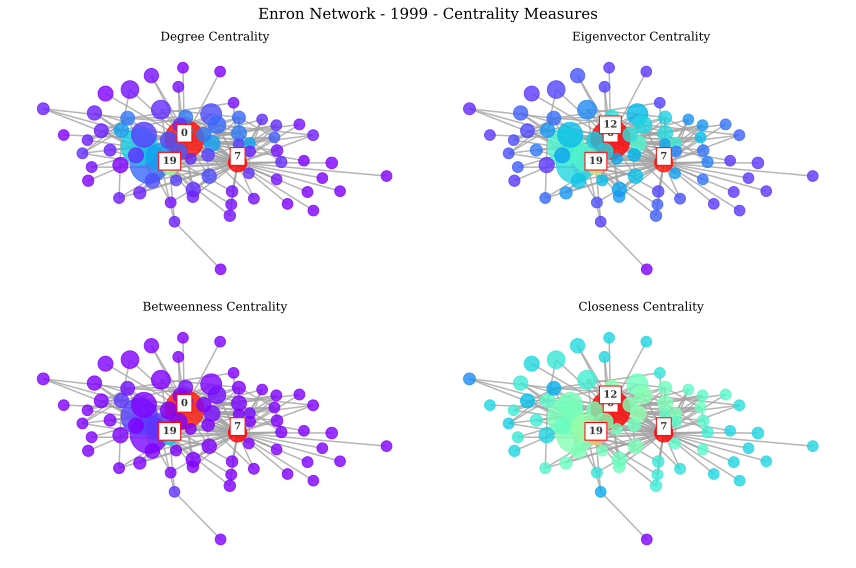

In [10]:
degree_cent = nx.degree_centrality(G1)
eigenvector_cent = nx.eigenvector_centrality(G1)
betweenness_cent = nx.betweenness_centrality(G1)
closeness_cent = nx.closeness_centrality(G1)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

centrality_measures = ['Degree Centrality', 'Eigenvector Centrality', 'Betweenness Centrality', 'Closeness Centrality']
centrality_values = [degree_cent, eigenvector_cent, betweenness_cent, closeness_cent]

for i, (centrality_measure, centrality_value) in enumerate(zip(centrality_measures, centrality_values)):
    pos = nx.spring_layout(G1, seed=42, iterations=100, k=1)

    node_size = [250 * scores_1999[v] for v in G1]
    node_color = [centrality_value[v] for v in G1.nodes]
    edge_color = '#A2A2A2'

    nx.draw_networkx(G1,
                     pos=pos,
                     with_labels=False,
                     width=1.5,
                     node_size=node_size,
                     node_color=node_color,
                     edge_color=edge_color,
                     alpha=0.8,
                     cmap='rainbow',
                     ax=axs[i])

    for key, value in pos.items():
        if centrality_measure == 'Degree Centrality':
            if centrality_value[key] >= 0.225:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Eigenvector Centrality':
            if centrality_value[key] >= 0.175:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Betweenness Centrality':
            if centrality_value[key] >= 0.1:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        else:
            if centrality_value[key] >= 0.55:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')

    axs[i].axis('off')
    axs[i].set_title(centrality_measure, fontsize=12)

plt.suptitle('Enron Network - 1999 - Centrality Measures', fontsize=15)
plt.tight_layout()
plt.show()


Each step described above has been repeated for the year 2000, 2001, 2002

# 2000

In [11]:
G2000 = nx.Graph()
l=[]
for i,j,k in zip(df_2000['sender'], df_2000['recipient1'], df_2000['counts']):
    l.append((i,j,k))
G2000.add_weighted_edges_from(l)

G2000 = disparity_filter(G2000)
G2000 = disparity_filter_alpha_cut(G2000)

degree_centrality = nx.degree_centrality(G2000)
btw_centrality = nx.betweenness_centrality(G2000, weight='weights')
closeness_centrality = nx.closeness_centrality(G2000)
eig_betw = nx.eigenvector_centrality(G2000, weight='weights')

df_nodes = pd.DataFrame()
df_nodes['nodes'] = [i for i in G2000]
df_nodes['degree_cent']  = dict(degree_centrality).values()
df_nodes['btw_cent']  = dict(btw_centrality).values()    
df_nodes['closeness_cent']  = dict(closeness_centrality).values()   
df_nodes['eigenvector_cent']  = dict(eig_betw).values()

df_nodes.head()

,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent
0,jeffrey.hodge@enron.com,0.008883,0.008559,0.285895,0.030174
1,colleen.sullivan@enron.com,0.008249,0.014901,0.294780,0.027079
2,ed.mcmichael@enron.com,0.001904,0.000597,0.277997,0.029270
3,jenny.helton@enron.com,0.002538,0.001434,0.245383,0.006319
4,mark.haedicke@enron.com,0.016497,0.019922,0.289508,0.036491


In [12]:
df_nodes['degree_cent'] = df_nodes['degree_cent']/df_nodes['degree_cent'].sum()
df_nodes['btw_cent'] = df_nodes['btw_cent']/df_nodes['btw_cent'].sum()
df_nodes['closeness_cent'] = df_nodes['closeness_cent']/df_nodes['closeness_cent'].sum()
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']/df_nodes['eigenvector_cent'].sum()

df_nodes['degree_cent'] = df_nodes['degree_cent']*10
df_nodes['btw_cent'] = df_nodes['btw_cent']*20
df_nodes['closeness_cent'] = df_nodes['closeness_cent']*30
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']*40

df_nodes['total'] = df_nodes['degree_cent']+df_nodes['btw_cent']+df_nodes['closeness_cent']+df_nodes['eigenvector_cent']

df_nodes=df_nodes.sort_values(by=['total'], ascending=False).reset_index(drop=True)

df_nodes.head()

,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent,total
0,vince.kaminski@enron.com,0.286797,1.318298,0.029683,0.897651,2.532429
1,steven.kean@enron.com,0.254329,1.025884,0.027931,0.783274,2.091418
2,sally.beck@enron.com,0.183983,0.675198,0.027425,0.331802,1.218406
3,david.delainey@enron.com,0.124459,0.512769,0.027553,0.364216,1.028996
4,john.lavorato@enron.com,0.126263,0.432055,0.028020,0.401905,0.988242


In [13]:
people_2000=df_nodes['nodes'].head(75).tolist()
scores_2000=df_nodes['total'].head(75).tolist()

node_2000=df_2000[(df_2000['sender'].isin(people_2000)) & (df_2000['recipient1'].isin(people_2000))]

G = nx.Graph()
l=[]
for i,j,k in zip(node_2000['sender'], node_2000['recipient1'], node_2000['counts']):
    l.append((i,j,k))
G.add_weighted_edges_from(l)


In [14]:
node_dict_2 = {node: index for index, node in enumerate(G.nodes())}

G2 = nx.relabel_nodes(G, node_dict_2)

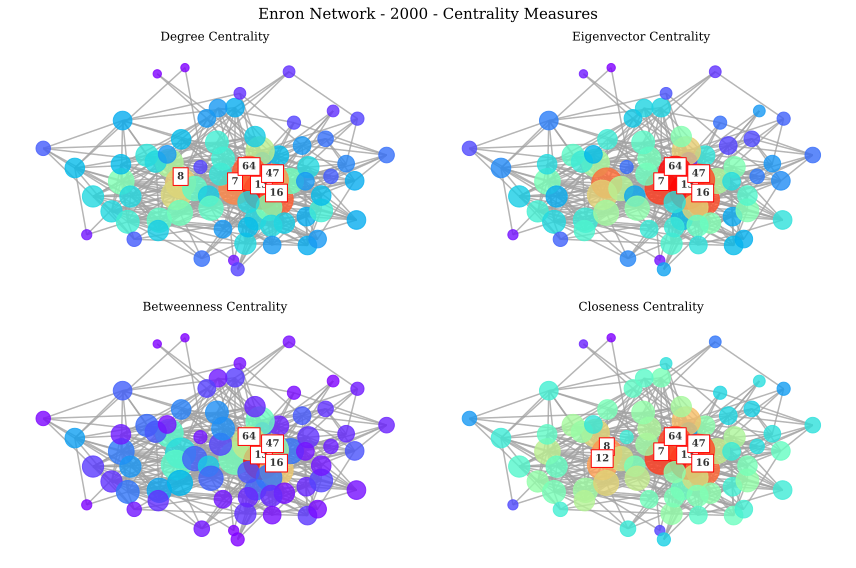

In [15]:
degree_cent = nx.degree_centrality(G2)
eigenvector_cent = nx.eigenvector_centrality(G2)
betweenness_cent = nx.betweenness_centrality(G2)
closeness_cent = nx.closeness_centrality(G2)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

centrality_measures = ['Degree Centrality', 'Eigenvector Centrality', 'Betweenness Centrality', 'Closeness Centrality']
centrality_values = [degree_cent, eigenvector_cent, betweenness_cent, closeness_cent]

for i, (centrality_measure, centrality_value) in enumerate(zip(centrality_measures, centrality_values)):
    pos = nx.spring_layout(G2, seed=42, iterations=100, k=2)

    node_size = [35 * G2.degree [v] for v in G2]
    node_color = [centrality_value[v] for v in G2.nodes]
    edge_color = '#A2A2A2'

    nx.draw_networkx(G2,
                     pos=pos,
                     with_labels=False,
                     width=1.5,
                     node_size=node_size,
                     node_color=node_color,
                     edge_color=edge_color,
                     alpha=0.8,
                     cmap='rainbow',
                     ax=axs[i])

    for key, value in pos.items():
        if centrality_measure == 'Degree Centrality':
            if centrality_value[key] >= 0.35:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Eigenvector Centrality':
            if centrality_value[key] >= 0.232:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Betweenness Centrality':
            if centrality_value[key] >= 0.05:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        else:
            if centrality_value[key] >= 0.575:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')

    axs[i].axis('off')
    axs[i].set_title(centrality_measure, fontsize=12)

plt.suptitle('Enron Network - 2000 - Centrality Measures', fontsize=15)
plt.tight_layout()
plt.show()


# 2001

In [16]:
G2001 = nx.Graph()
l=[]
for i,j,k in zip(df_2001['sender'], df_2001['recipient1'], df_2001['counts']):
    l.append((i,j,k))
G2001.add_weighted_edges_from(l)

G2001 = disparity_filter(G2001)
G2001 = disparity_filter_alpha_cut(G2001)

degree_centrality = nx.degree_centrality(G2001)
btw_centrality = nx.betweenness_centrality(G2001, weight='weights')
closeness_centrality = nx.closeness_centrality(G2001)
eig_betw = nx.eigenvector_centrality(G2001, weight='weights')

df_nodes = pd.DataFrame()
df_nodes['nodes'] = [i for i in G2001]
df_nodes['degree_cent']  = dict(degree_centrality).values()
df_nodes['btw_cent']  = dict(btw_centrality).values()    
df_nodes['closeness_cent']  = dict(closeness_centrality).values()   
df_nodes['eigenvector_cent']  = dict(eig_betw).values()

df_nodes.head()



,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent
0,kimberly.hundl@enron.com,0.001268,0.000258,0.251520,0.012381
1,kate.symes@enron.com,0.030008,0.043184,0.294408,0.048888
2,sara.shackleton@enron.com,0.035503,0.043194,0.323332,0.161022
3,sharen.cason@enron.com,0.003804,0.000268,0.246092,0.008078
4,mark.fischer@enron.com,0.001691,0.000274,0.227896,0.003153


In [17]:
df_nodes['degree_cent'] = df_nodes['degree_cent']/df_nodes['degree_cent'].sum()
df_nodes['btw_cent'] = df_nodes['btw_cent']/df_nodes['btw_cent'].sum()
df_nodes['closeness_cent'] = df_nodes['closeness_cent']/df_nodes['closeness_cent'].sum()
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']/df_nodes['eigenvector_cent'].sum()

df_nodes['degree_cent'] = df_nodes['degree_cent']*10
df_nodes['btw_cent'] = df_nodes['btw_cent']*20
df_nodes['closeness_cent'] = df_nodes['closeness_cent']*30
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']*40

df_nodes['total'] = df_nodes['degree_cent']+df_nodes['btw_cent']+df_nodes['closeness_cent']+df_nodes['eigenvector_cent']

df_nodes=df_nodes.sort_values(by=['total'], ascending=False).reset_index(drop=True)

df_nodes.head()

,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent,total
0,steven.kean@enron.com,0.193508,0.832970,0.018344,0.629538,1.674361
1,vince.kaminski@enron.com,0.115481,0.487080,0.017854,0.259424,0.879839
2,tana.jones@enron.com,0.116521,0.382712,0.017903,0.328167,0.845303
3,sally.beck@enron.com,0.106117,0.475452,0.018129,0.212903,0.812601
4,louise.kitchen@enron.com,0.094673,0.393670,0.018409,0.280602,0.787354


In [18]:
people_2001=df_nodes['nodes'].head(75).tolist()
scores_2001=df_nodes['total'].head(75).tolist()

node_01=df_2001[(df_2001['sender'].isin(people_2001)) & (df_2001['recipient1'].isin(people_2001))]

G = nx.Graph()
l=[]
for i,j,k in zip(node_01['sender'], node_01['recipient1'], node_01['counts']):
    l.append((i,j,k))
G.add_weighted_edges_from(l)

In [19]:
node_dict_3 = {node: index for index, node in enumerate(G.nodes())}

G3 = nx.relabel_nodes(G, node_dict_3)

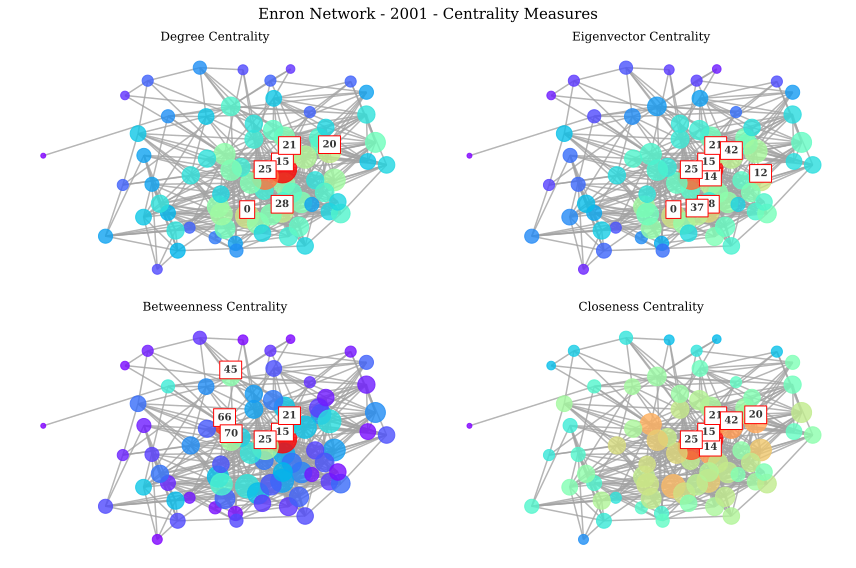

In [20]:
# Calculate centrality measures
degree_cent = nx.degree_centrality(G3)
eigenvector_cent = nx.eigenvector_centrality(G3)
betweenness_cent = nx.betweenness_centrality(G3)
closeness_cent = nx.closeness_centrality(G3)

# Set up the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

centrality_measures = ['Degree Centrality', 'Eigenvector Centrality', 'Betweenness Centrality', 'Closeness Centrality']
centrality_values = [degree_cent, eigenvector_cent, betweenness_cent, closeness_cent]

# Iterate over the centrality measures and create subplots
for i, (centrality_measure, centrality_value) in enumerate(zip(centrality_measures, centrality_values)):
    pos = nx.spring_layout(G3, seed=42, iterations=100, k=2)

    node_size = [25 * G3.degree(v) for v in G3]
    node_color = [centrality_value[v] for v in G3.nodes]
    edge_color = '#A2A2A2'

    nx.draw_networkx(G3,
                     pos=pos,
                     with_labels=False,
                     width=1.5,
                     node_size=node_size,
                     node_color=node_color,
                     edge_color=edge_color,
                     alpha=0.8,
                     cmap='rainbow',
                     ax=axs[i])

    for key, value in pos.items():
        if centrality_measure == 'Degree Centrality':
            if centrality_value[key] >= 0.28:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Eigenvector Centrality':
            if centrality_value[key] >= 0.17:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Betweenness Centrality':
            if centrality_value[key] >= 0.035:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        else:
            if centrality_value[key] >= 0.55:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')

    axs[i].axis('off')
    axs[i].set_title(centrality_measure, fontsize=12)

plt.suptitle('Enron Network - 2001 - Centrality Measures', fontsize=15)
plt.tight_layout()
plt.show()


# 2002

In [21]:
G2002 = nx.Graph()
l=[]
for i,j,k in zip(df_2002['sender'], df_2002['recipient1'], df_2002['counts']):
    l.append((i,j,k))
G2002.add_weighted_edges_from(l)

G2002 = disparity_filter(G2002)
G2002 = disparity_filter_alpha_cut(G2002)

degree_centrality = nx.degree_centrality(G2002)
btw_centrality = nx.betweenness_centrality(G2002, weight='weights')
closeness_centrality = nx.closeness_centrality(G2002)
eig_betw = nx.eigenvector_centrality(G2002, weight='weights')

df_nodes = pd.DataFrame()
df_nodes['nodes'] = [i for i in G2002]
df_nodes['degree_cent']  = dict(degree_centrality).values()
df_nodes['btw_cent']  = dict(btw_centrality).values()    
df_nodes['closeness_cent']  = dict(closeness_centrality).values()   
df_nodes['eigenvector_cent']  = dict(eig_betw).values()

df_nodes.head()

,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent
0,eric.bass@enron.com,0.008715,0.011616,0.156819,0.000142
1,joe.parks@enron.com,0.041394,0.078058,0.189618,0.001076
2,charles.weldon@enron.com,0.002179,0.000000,0.133399,0.000018
3,matthew.lenhart@enron.com,0.002179,0.000000,0.133399,0.000018
4,timothy.blanchard@enron.com,0.002179,0.000000,0.133399,0.000018


In [22]:
df_nodes['degree_cent'] = df_nodes['degree_cent']/df_nodes['degree_cent'].sum()
df_nodes['btw_cent'] = df_nodes['btw_cent']/df_nodes['btw_cent'].sum()
df_nodes['closeness_cent'] = df_nodes['closeness_cent']/df_nodes['closeness_cent'].sum()
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']/df_nodes['eigenvector_cent'].sum()

df_nodes['degree_cent'] = df_nodes['degree_cent']*10
df_nodes['btw_cent'] = df_nodes['btw_cent']*20
df_nodes['closeness_cent'] = df_nodes['closeness_cent']*30
df_nodes['eigenvector_cent'] = df_nodes['eigenvector_cent']*40

df_nodes['total'] = df_nodes['degree_cent']+df_nodes['btw_cent']+df_nodes['closeness_cent']+df_nodes['eigenvector_cent']

df_nodes=df_nodes.sort_values(by=['total'], ascending=False).reset_index(drop=True)

df_nodes.head()

,nodes,degree_cent,btw_cent,closeness_cent,eigenvector_cent,total
0,shelley.corman@enron.com,0.305755,0.784219,0.095945,2.410821,3.596741
1,kimberly.watson@enron.com,0.197842,0.438944,0.092997,1.858513,2.588295
2,michelle.lokay@enron.com,0.161871,0.402596,0.094904,1.695646,2.355016
3,lindy.donoho@enron.com,0.161871,0.264998,0.090483,1.449557,1.966909
4,teb.lokey@enron.com,0.152878,0.274088,0.089556,1.442814,1.959336


In [23]:
people_2002=df_nodes['nodes'].head(75).tolist()

node_02=df_2002[(df_2002['sender'].isin(people_2002)) & (df_2002['recipient1'].isin(people_2002))]

G = nx.Graph()
l=[]
for i,j,k in zip(node_02['sender'], node_02['recipient1'], node_02['counts']):
    l.append((i,j,k))
G.add_weighted_edges_from(l)

In [24]:
node_dict_4 = {node: index for index, node in enumerate(G.nodes())}

G4 = nx.relabel_nodes(G, node_dict_4)

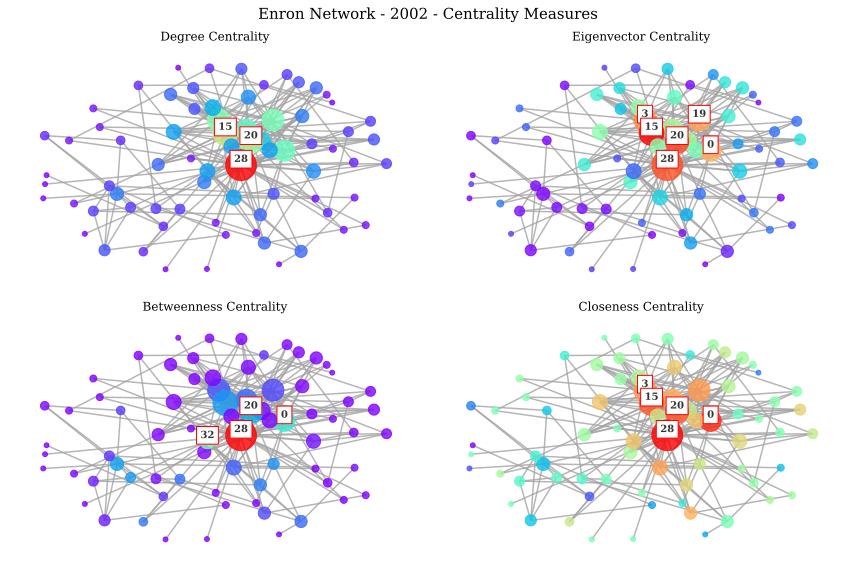

In [25]:
# Calculate centrality measures
degree_cent = nx.degree_centrality(G4)
eigenvector_cent = nx.eigenvector_centrality(G4)
betweenness_cent = nx.betweenness_centrality(G4)
closeness_cent = nx.closeness_centrality(G4)

# Set up the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

centrality_measures = ['Degree Centrality', 'Eigenvector Centrality', 'Betweenness Centrality', 'Closeness Centrality']
centrality_values = [degree_cent, eigenvector_cent, betweenness_cent, closeness_cent]

# Iterate over the centrality measures and create subplots
for i, (centrality_measure, centrality_value) in enumerate(zip(centrality_measures, centrality_values)):
    pos = nx.spring_layout(G4, seed=42, iterations=100, k=2)

    node_size = [25 * G4.degree(v) for v in G4]
    node_color = [centrality_value[v] for v in G4.nodes]
    edge_color = '#A2A2A2'

    nx.draw_networkx(G4,
                     pos=pos,
                     with_labels=False,
                     width=1.5,
                     node_size=node_size,
                     node_color=node_color,
                     edge_color=edge_color,
                     alpha=0.8,
                     cmap='rainbow',
                     ax=axs[i])

    for key, value in pos.items():
        if centrality_measure == 'Degree Centrality':
            if centrality_value[key] >= 0.28:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Eigenvector Centrality':
            if centrality_value[key] >= 0.25:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        elif centrality_measure == 'Betweenness Centrality':
            if centrality_value[key] >= 0.1:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')
        else:
            if centrality_value[key] >= 0.45:
                x, y = value[0], value[1]
                axs[i].text(x, y + 0.03, s=key, bbox=dict(facecolor='white', alpha=1, edgecolor='red'),
                            horizontalalignment='center', fontsize=10, fontweight='bold', color='#333333')

    axs[i].axis('off')
    axs[i].set_title(centrality_measure, fontsize=12)

plt.suptitle('Enron Network - 2002 - Centrality Measures', fontsize=15)
plt.tight_layout()
plt.show()


# Community Detection

Finally, a community detection analysis was conducted on the network to identify densely connected communities of nodes. The Louvain method, a greedy optimization technique, was utilized to optimize the modularity score of the network partition. The modularity score serves as a quality measure for the network's division into communities. It is calculated as the fraction of edges within identified communities minus the expected fraction if the edges were randomly distributed. The modularity score ranges between -1 and 1, with higher scores indicating a more effective partitioning of the network. This analysis aims to reveal inherent structures and patterns within the network through the identification of densely connected communities.

The community detection analysis was executed on the network for each year, and the communities with the highest modularity scores were visualized. Node coloring was employed based on their respective community affiliations. Additionally, induced subgraphs were generated for each community to enhance the visualization and provide a more detailed representation of the identified communities.

In [26]:
louvain_partition1999 = community_louvain.best_partition(G1,weight = 'weight', random_state = 42)

louvain_partition2000 = community_louvain.best_partition(G2,weight = 'weight', random_state = 42)

louvain_partition2001 = community_louvain.best_partition(G3,weight = 'weight', random_state = 42)

louvain_partition2002 = community_louvain.best_partition(G4,weight = 'weight', random_state = 42)

In [27]:
Q1999 = community_louvain.modularity(louvain_partition1999, G1, weight = 'weight')
Q2000 = community_louvain.modularity(louvain_partition2000, G2, weight = 'weight')
Q2001 = community_louvain.modularity(louvain_partition2001, G3, weight = 'weight')
Q2002 = community_louvain.modularity(louvain_partition2002, G4, weight = 'weight')

In [28]:
dendro1999 = community_louvain.generate_dendrogram(G1, random_state=42)
dendro2000 = community_louvain.generate_dendrogram(G2, random_state=42)
dendro2001 = community_louvain.generate_dendrogram(G3, random_state=42)
dendro2002 = community_louvain.generate_dendrogram(G4, random_state=42)  

(-1.209922564506991, 1.2091850836211924, -0.932163543743821, 0.735816341661277)

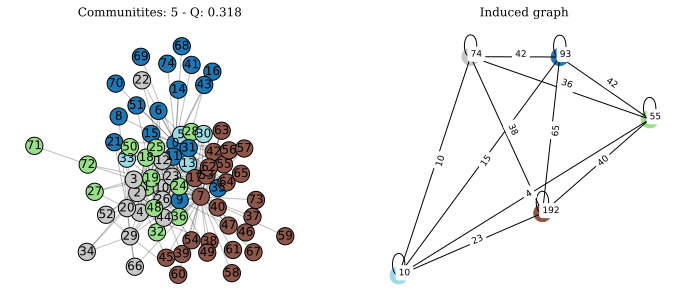

In [29]:
# Community detection - 1999

fig, axes = plt.subplots(1,2, figsize = (12,5))
original_club_color = ['k' for node in G1.nodes()]
pos = nx.spring_layout(G1, seed=666, iterations = 5000, k=20)


part = community_louvain.partition_at_level(dendro1999, 1)
mod_1 = community_louvain.modularity(part, G1, weight = 'weight')
    
# graph with communities
nx.draw_networkx_nodes(G1, 
                        pos, 
                        node_color= list(part.values()),
                        edgecolors= original_club_color,
                        linewidths= 1,
                        cmap=plt.cm.tab20,
                        ax = axes[0])
nx.draw_networkx_edges(G1, 
                        pos, 
                        ax = axes[0],
                        width=1,
                        alpha = .25)
nx.draw_networkx_labels(G1, pos, ax = axes[0])

axes[0].set_title(f"Communitites: {len(set(part.values()))} - Q: {round(mod_1, 3)}")

# induced graph 
ind = community_louvain.induced_graph(part, G1)   

pos_ind = nx.spring_layout(ind, seed = 20)
no = nx.draw_networkx_nodes(ind,
                    node_color = pd.Series(part).drop_duplicates().values,
                    cmap=plt.cm.tab20,
                    pos= pos_ind, ax =axes[1])
ed = nx.draw_networkx_edges(ind, 
                pos = pos_ind, 
                ax = axes[1])
# plot the edge labels
el = nx.draw_networkx_edge_labels(ind,
                                    edge_labels = nx.get_edge_attributes(ind, 'weight'), 
                                            verticalalignment='baseline',
                                            horizontalalignment = 'left',
                                            font_size = 9,
                                    pos=pos_ind, ax = axes[1])
no.set_zorder(1)
axes[1].set_title(f"Induced graph")

axes[0].axis('off')
axes[1].axis('off')

In [30]:
# filter the names in the partition to get the names of the nodes in each community

part_names = {}
for com in set(louvain_partition1999.values()) :
    part_names[com] = [nodes for nodes in louvain_partition1999.keys() if louvain_partition1999[nodes] == com]

# print the names of the nodes in each community
for key, value in part_names.items():
    print(f'Community {key}: {value}')



Community 0: [0, 6, 8, 9, 11, 14, 15, 16, 21, 31, 35, 41, 43, 51, 68, 69, 70, 74]
Community 1: [1, 18, 19, 24, 25, 27, 28, 32, 36, 48, 50, 71, 72]
Community 2: [7, 17, 37, 38, 39, 40, 42, 45, 46, 47, 49, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 73]
Community 3: [2, 3, 4, 10, 12, 20, 22, 23, 26, 29, 34, 44, 52, 66]
Community 4: [5, 13, 30, 33]


(-0.7740420145728142,
 0.6730029831987926,
 -1.1855036555431677,
 0.9973998259648045)

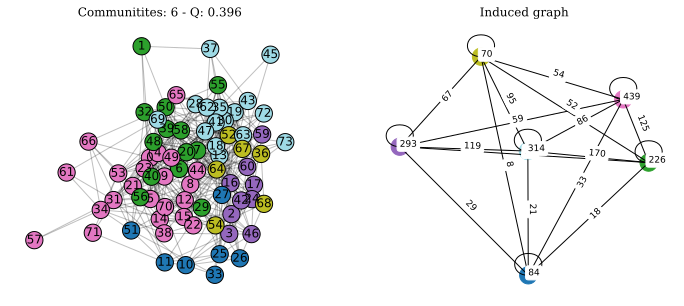

In [31]:
# Community detection - 2000

fig, axes = plt.subplots(1,2, figsize = (12,5))
original_club_color = ['k' for node in G2.nodes()]
pos = nx.spring_layout(G2, seed=666, iterations = 5000, k=30)


part = community_louvain.partition_at_level(dendro2000, 1)
mod_1 = community_louvain.modularity(part, G2, weight = 'weight')
    
# graph with communities
nx.draw_networkx_nodes(G2, 
                        pos, 
                        node_color= list(part.values()),
                        edgecolors= original_club_color,
                        linewidths= 1,
                        cmap=plt.cm.tab20,
                        ax = axes[0])
nx.draw_networkx_edges(G2, 
                        pos, 
                        ax = axes[0],
                        width=1,
                        alpha = .25)
nx.draw_networkx_labels(G2, pos, ax = axes[0])

axes[0].set_title(f"Communitites: {len(set(part.values()))} - Q: {round(mod_1, 3)}")

# induced graph 
ind = community_louvain.induced_graph(part, G2)   

pos_ind = nx.spring_layout(ind, seed = 20)
no = nx.draw_networkx_nodes(ind,
                    node_color = pd.Series(part).drop_duplicates().values,
                    cmap=plt.cm.tab20,
                    pos= pos_ind, ax =axes[1])
ed = nx.draw_networkx_edges(ind, 
                pos = pos_ind, 
                ax = axes[1])
# plot the edge labels
el = nx.draw_networkx_edge_labels(ind,
                                    edge_labels = nx.get_edge_attributes(ind, 'weight'), 
                                            verticalalignment='baseline',
                                            horizontalalignment = 'left',
                                            font_size = 9,
                                    pos=pos_ind, ax = axes[1])
no.set_zorder(1)
axes[1].set_title(f"Induced graph")

axes[0].axis('off')
axes[1].axis('off')

(-0.4759570460527154,
 0.4653919805211858,
 -1.1851916964483262,
 0.9940408245482584)

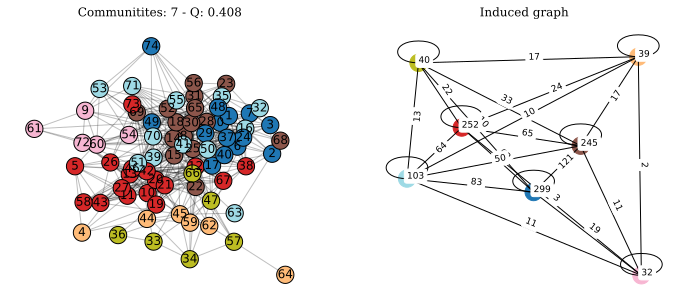

In [32]:
# Community detection - 2001

fig, axes = plt.subplots(1,2, figsize = (12,5))
original_club_color = ['k' for node in G3.nodes()]
pos = nx.spring_layout(G3, seed=666, iterations = 5000, k=70)


part = community_louvain.partition_at_level(dendro2001, 1)
mod_1 = community_louvain.modularity(part, G3, weight = 'weight')
    
# graph with communities
nx.draw_networkx_nodes(G3, 
                        pos, 
                        node_color= list(part.values()),
                        edgecolors= original_club_color,
                        linewidths= 1,
                        cmap=plt.cm.tab20,
                        ax = axes[0])
nx.draw_networkx_edges(G3, 
                        pos, 
                        ax = axes[0],
                        width=1,
                        alpha = .25)
nx.draw_networkx_labels(G3, pos, ax = axes[0])

axes[0].set_title(f"Communitites: {len(set(part.values()))} - Q: {round(mod_1, 3)}")

# induced graph 
ind = community_louvain.induced_graph(part, G3)   

pos_ind = nx.spring_layout(ind, seed = 20)
no = nx.draw_networkx_nodes(ind,
                    node_color = pd.Series(part).drop_duplicates().values,
                    cmap=plt.cm.tab20,
                    pos= pos_ind, ax =axes[1])
ed = nx.draw_networkx_edges(ind, 
                pos = pos_ind, 
                ax = axes[1])
# plot the edge labels
el = nx.draw_networkx_edge_labels(ind,
                                    edge_labels = nx.get_edge_attributes(ind, 'weight'), 
                                            verticalalignment='baseline',
                                            horizontalalignment = 'left',
                                            font_size = 9,
                                    pos=pos_ind, ax = axes[1])
no.set_zorder(1)
axes[1].set_title(f"Induced graph")

axes[0].axis('off')
axes[1].axis('off')

(-0.6786672248954542,
 0.7552062711237573,
 -1.174117505611088,
 1.309186010955979)

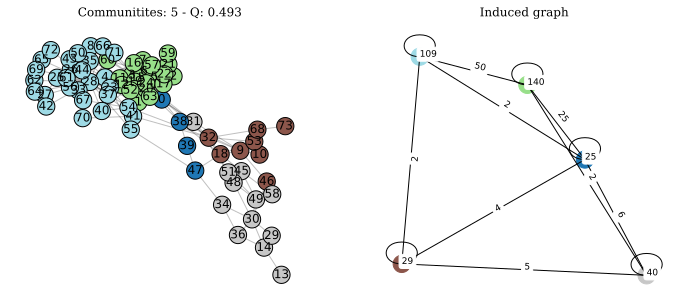

In [33]:
# Community detection - 2002

fig, axes = plt.subplots(1,2, figsize = (12,5))
original_club_color = ['k' for node in G4.nodes()]
pos = nx.spring_layout(G4, seed=666, iterations = 5000, k=20)


part = community_louvain.partition_at_level(dendro2002, 1)
mod_1 = community_louvain.modularity(part, G4, weight = 'weight')
    
# graph with communities
nx.draw_networkx_nodes(G4, 
                        pos, 
                        node_color= list(part.values()),
                        edgecolors= original_club_color,
                        linewidths= 1,
                        cmap=plt.cm.tab20,
                        ax = axes[0])
nx.draw_networkx_edges(G4, 
                        pos, 
                        ax = axes[0],
                        width=1,
                        alpha = .25)
nx.draw_networkx_labels(G4, pos, ax = axes[0])

axes[0].set_title(f"Communitites: {len(set(part.values()))} - Q: {round(mod_1, 3)}")

# induced graph 
ind = community_louvain.induced_graph(part, G4)   

pos_ind = nx.spring_layout(ind, seed = 20)
no = nx.draw_networkx_nodes(ind,
                    node_color = pd.Series(part).drop_duplicates().values,
                    cmap=plt.cm.tab20,
                    pos= pos_ind, ax =axes[1])
ed = nx.draw_networkx_edges(ind, 
                pos = pos_ind, 
                ax = axes[1])
# plot the edge labels
el = nx.draw_networkx_edge_labels(ind,
                                    edge_labels = nx.get_edge_attributes(ind, 'weight'), 
                                            verticalalignment='baseline',
                                            horizontalalignment = 'left',
                                            font_size = 9,
                                    pos=pos_ind, ax = axes[1])
no.set_zorder(1)
axes[1].set_title(f"Induced graph")

axes[0].axis('off')
axes[1].axis('off')

In [34]:
len(louvain_partition1999)
t = np.arange(0,75)
df = pd.DataFrame(t).rename(columns={0:"node"})
df["lv"] = louvain_partition1999.values()
df["person"]=node_dict_1.keys()
set(list(df['lv']))

# going through each commuity so see if there is one with particularly many convicted
df0 = df[df['lv']==4]

len(louvain_partition2000)
t = np.arange(0,74)
df = pd.DataFrame(t).rename(columns={0:"node"})
df["lv"] = louvain_partition2000.values()
df["person"]=node_dict_2.keys()
set(list(df['lv']))

# going through each commuity so see if there is one with particularly many convicted
df1 = df[df['lv']==5]
df1



,node,lv,person
13,13,5,vince.kaminski@enron.com
18,18,5,greg.whalley@enron.com
19,19,5,john.sherriff@enron.com
28,28,5,ted.murphy@enron.com
30,30,5,mike.mcconnell@enron.com
35,35,5,sally.beck@enron.com
37,37,5,brent.price@enron.com
41,41,5,rick.buy@enron.com
43,43,5,richard.causey@enron.com
45,45,5,patti.thompson@enron.com


In [35]:
len(louvain_partition2001)
t = np.arange(0,75)
df = pd.DataFrame(t).rename(columns={0:"node"})
df["lv"] = louvain_partition2001.values()
df["person"]=node_dict_3.keys()
set(list(df['lv']))

# going through each commuity so see if there is one with particularly many convicted
df2 = df[df['lv']==3]
df2

# this community has three people who were convicted along with four people with 
# suspicious behaviour 

,node,lv,person
8,8,3,vince.kaminski@enron.com
14,14,3,sally.beck@enron.com
15,15,3,louise.kitchen@enron.com
18,18,3,michelle.cash@enron.com
22,22,3,john.arnold@enron.com
23,23,3,kenneth.lay@enron.com
25,25,3,john.lavorato@enron.com
28,28,3,greg.whalley@enron.com
30,30,3,jeffrey.shankman@enron.com
31,31,3,jeff.skilling@enron.com


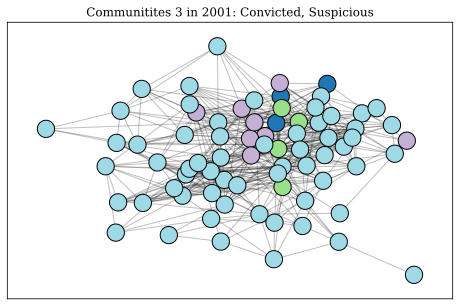

In [36]:
# creating a coloured column so to graph the community singling out the suspicious and 
# convicted employees 
df['color']= 0.5
df.loc[df['lv'] == 3, 'color'] = 0.3
df['color'].loc[28]=0.2
df['color'].loc[23]=0.1
df['color'].loc[31]=0.1
df['color'].loc[30]=0.1
df['color'].loc[25]=0.2
df['color'].loc[22]=0.2
df['color'].loc[65]=0.2
df.tail(16)


# graphing community three singling out the suspicious and convicted employees 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, figsize=(8, 5))  # Only one subplot for the first graph
original_club_color = ['k' for node in G3.nodes()]
pos = nx.spring_layout(G3, seed=666, iterations=5000, k=70)

part = community_louvain.partition_at_level(dendro2001, 1)
mod_1 = community_louvain.modularity(part, G3, weight='weight')

# Graph with communities
nx.draw_networkx_nodes(
    G3,
    pos,
    node_color=list(df['color']),
    edgecolors=original_club_color,
    linewidths=1,
    cmap=plt.cm.tab20,
    ax=axes
)
nx.draw_networkx_edges(G3, pos, ax=axes, width=1, alpha=0.25)

axes.set_title(f"Communitites 3 in 2001: Convicted, Suspicious")



plt.show()

In [37]:
len(louvain_partition2002)
t = np.arange(0,74)
df = pd.DataFrame(t).rename(columns={0:"node"})
df["lv"] = louvain_partition2002.values()
df["person"]=node_dict_4.keys()
set(list(df['lv']))

# going through each commuity so see if there is one with particularly many convicted
df3 = df[df['lv']==4]
df

,node,lv,person
0,0,0,kevin.hyatt@enron.com
1,1,1,julie.armstrong@enron.com
2,2,1,ron.matthews@enron.com
3,3,1,lindy.donoho@enron.com
4,4,4,teb.lokey@enron.com
...,...,...,...
69,69,4,keith.braswell@enron.com
70,70,4,rita.houston@enron.com
71,71,4,ruthann.frausto@enron.com
72,72,4,michael.wagoner@enron.com
